---
title: Closed capture-recapture
description: Closed population capture-recapture models using data augmentation
author:
  name: Philip T. Patton
  affiliation:
    - Marine Mammal Research Program
    - Hawaiʻi Institute of Marine Biology
date: today
format:
  html:
    html-math-method: mathjax
    code-overflow: wrap
bibliography: refs.bib
jupyter: pymc_env
---

In this notebook, I explore fitting closed population capture-recapture models in PyMC. Capture-recapture, at least the Lincoln-Peterson estimator, has been around for almost 100 years. Since then, countless varieties of capture-recapture models have been developed for closed populations [@otis1978].

The basic steps in capture-recapture are: capture several individuals--e.g., via trapping--from the population of interest, mark these animals, then release them. We repeat this process several times, each time noting when we recapture individuals.

| Individual  | $t_1$ | $t_2$ | $t_3$ | $t_4$ |
| ----------- | ----- | ----- | ----- | ----- |
| 001         | 1     | 1     | 0     | 1     |
| 002         | 0     | 1     | 1     | 1     |
| 003         | 0     | 0     | 1     | 1     |
: Example capture history, where $t$ is the sampling occasion and 1 indicates capture {#tbl-ch}

This produces a capture history for each individual, which allows us to estimate the probability of capture and the number of individuals in the population $N$.

# Model $M_0$

In [1]:
%config InlineBackend.figure_format = 'retina'

# libraries
from scipy.stats import binom
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_extras as pmx
import seaborn as sns

# only necessary on MacOS Sequoia
# https://discourse.pymc.io/t/pytensor-fails-to-compile-model-after-upgrading-to-mac-os-15-4/16796/5
import pytensor
pytensor.config.cxx = '/usr/bin/clang++'

# plotting parameters
plt.style.use('fivethirtyeight')
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = False
sns.set_palette("tab10")

# hyperparameters
SEED = 808
RNG = np.random.default_rng(SEED)

I explore fitting the simplest closed capture-recapture model, Model $M_0,$ through parameter-expanded data-augmentation [PX-DA, @royle2008]. The idea with PX-DA is to augment the capture histories with $M-n$ all zero capture-histories, where $M$ is a hyperparameter that should be much greater than the true population size $N,$ and $n$ is the total number of individuals that were captured during the study. This allows us to treat the data as a zero-inflated binomial distribution (see below).

In [2]:
def augment_history(history, M):
    '''Augment a capture history with all-zero histories.'''

    animals_captured, T = history.shape

    # create M - n all zero histories
    zero_history_count = M - animals_captured
    zero_history = np.zeros((zero_history_count, T))

    # tack those on to the capture history
    augmented = np.vstack((history, zero_history))

    return augmented

To demonstrate this approach, I use the salamander dataset from @bailey2004, as demonstrated in @hooten2019, Chapter 24. These data were collected on two salamander species, the red-cheeked salamander (*Plethodon jordani*) and the pygmy salamander (*Desmognathus wrighti*), in Great Smoky Mountains National Park. The salamanders were counted in 15m by 15m square plots. In this case, we augment the history by setting $M=1500$. There were $n=92$ individual red-cheeked and $n=132$ pygmy salamanders captured during the course of the survey.

In [3]:
def get_histories():
    '''Read, augment, and recombine the salamander histories.'''

    # read in salamander data
    sal_data = pd.read_csv('sal_data.csv')

    # labels for capture history columns
    col_labs = [f'y{t}' for t in range(1, 5)]

    # subset each dataset before augmenting
    is_pyg = sal_data.spp == 1
    is_red = sal_data.spp == 0

    pyg = sal_data.loc[is_pyg, col_labs].to_numpy()
    red = sal_data.loc[is_red, col_labs].to_numpy()

    return {'pyg': pyg, 'red': red}

def augment_histories(histories, M):

    pyg_augmented = augment_history(histories['pyg'], M=M)
    red_augmented = augment_history(histories['red'], M=M)

    # recombine into one history
    history = np.concatenate((pyg_augmented, red_augmented))

    return history

histories = get_histories()

n_red, T = histories['red'].shape
n_pyg, T = histories['pyg'].shape

# # summarize into binomial data
M = 1500
history_augmented = augment_histories(histories, M=M)
history_summarized = history_augmented.sum(axis=1)

For this model, I use the `pm.ZeroInflatedBinomial` class, just as I did in the [occupancy notebook](https://philpatton.github.io/occ.html). That said, the parameters here are different. First, $p$ represents the probability of capturing a given individual during the survey. Second, $\psi$ represents a mysterious entity known as the inclusion probability. That is, the probability that an individual from the hypothetical superpopulation $M$ is included in the population of interest $N.$ Then, we can simulate the posterior distribution for $N$ using $M$ and the posterior distributions of $\psi.$

In this example, I combine the two species into one `pm.Model` object, making use of `coords`. That said, the parameters for each species are treated as independent. In other words, this is a "no-pooling" model.

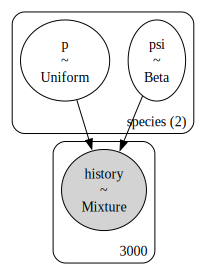

In [4]:
#| fig-cap: Visual representation of model $M_0.$ `MarginalMixture` refers to the zero-inflated binomial distribution.
#| label: fig-m0

# index for each species
species_idx = np.repeat([0, 1], M)

# coordinates identifying parameter each species
coords = {'species': ['pygmy', 'red_cheeked']}

with pm.Model(coords=coords) as M0:

    # priors for the capture and inclusion probabilities
    psi = pm.Beta('psi', 0.001, 1, dims='species')
    p = pm.Uniform('p', 0, 1, dims='species')

    # likelihood for the summarized data
    pm.ZeroInflatedBinomial(
        'history',
        p=p[species_idx],
        psi=psi[species_idx],
        n=T,
        observed=history_summarized
    )

pm.model_to_graphviz(M0)

In [5]:
with M0:
    M0_idata = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [psi, p]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


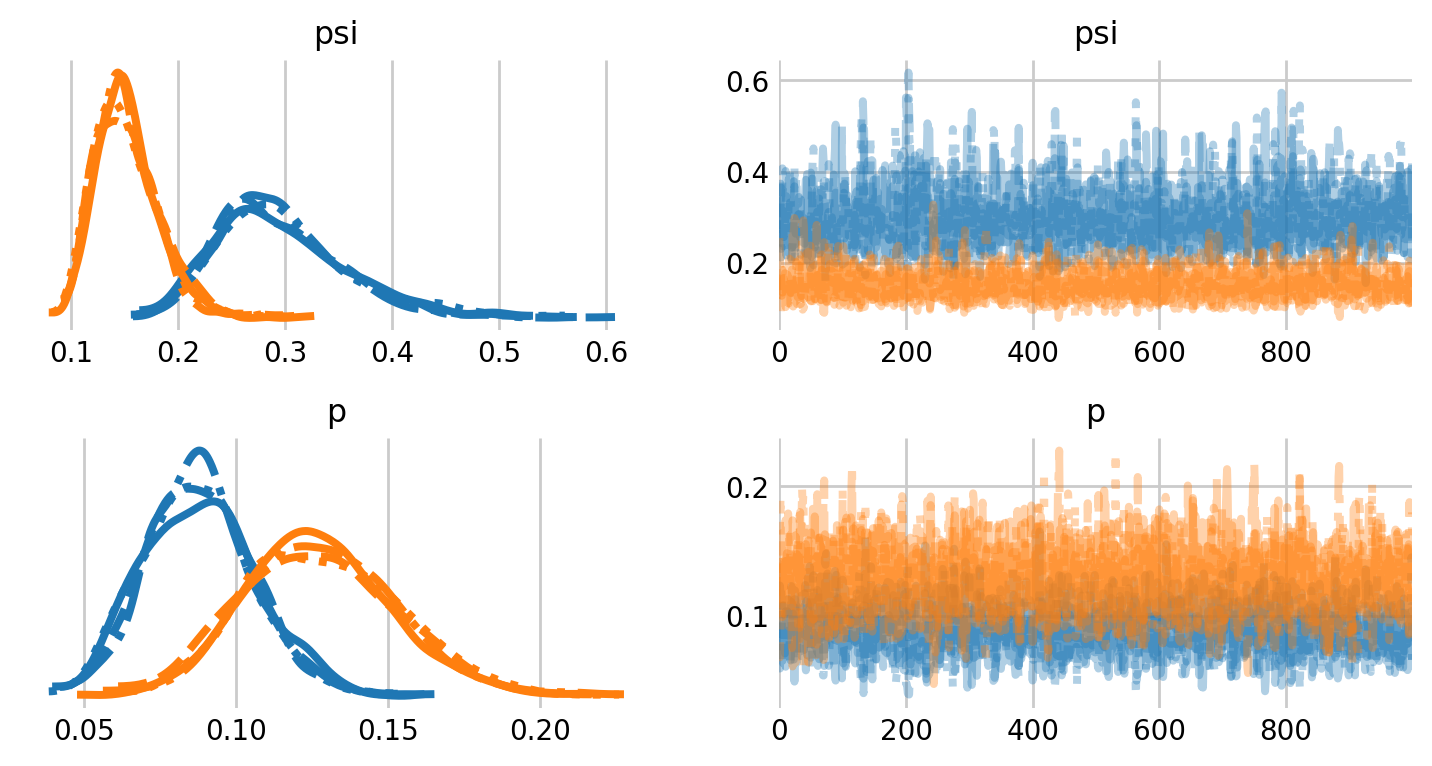

In [6]:
#| fig-cap: Traceplots for the salamander $M_0$ model. The red-cheeked salamander is in blue while the pygmy salamander is in red.
#| label: fig-trace

ax = az.plot_trace(M0_idata, figsize=(8,4), var_names=['psi', 'p']);
plt.subplots_adjust(hspace=0.4)

For faster sampling, it's better to separate the two species into two separate models. On my machine, the individual species models finish sampling in 2-3 seconds, compared to 15-20 seconds for the two species model. That said, the two species model is somewhat more convenient.

Of course, the trace plots lack our true parameter of interest: the population size $N.$ We can simulate the posterior of $N$ as a *derived quantity*, using $M$ and the posterior distribution of $\psi$.

In [7]:
# az.extract flattens the chains
posterior = az.extract(M0_idata)
psi_samps = posterior.psi.values
p_samps = posterior.p.values

# posterior probabilities of being present in the population but not detected
p_if_present = psi_samps * binom.pmf(0, n=T, p=p_samps)
p_total = p_if_present + (1 - psi_samps)

# simulate the number of undetected animals in each population
number_undetected_pyg = RNG.binomial(M - n_pyg, p_if_present[0] / p_total[0])
number_undetected_red = RNG.binomial(M - n_red, p_if_present[1] / p_total[1])

# simulate N
N_pyg = n_pyg + number_undetected_pyg
N_red = n_red + number_undetected_red

Below I plotted the posterior distributions of $N$ for both species, adding the estimates from @hooten2019, Chapter 24. Although note that they used a different prior for $\psi.$

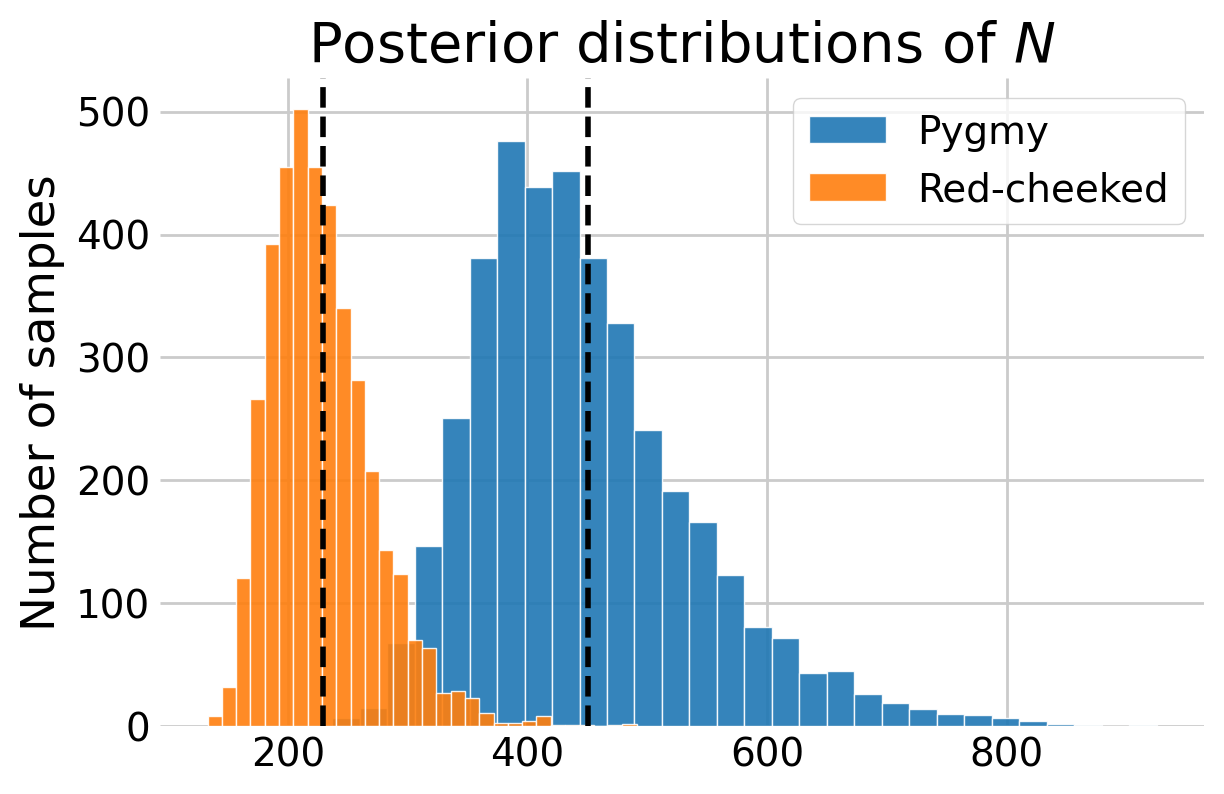

In [8]:
#| fig-cap: Posterior distributions of $N$ from the $M_0$ model. Estimates from @hooten2019 are shown by the vertical lines'
#| label: fig-N_trace

N_hooten = [229.6, 450.9]
fig, ax = plt.subplots(figsize=(6,4))
ax.hist(N_pyg, color='C0', edgecolor='white', alpha=0.9, bins=30, label='Pygmy')
ax.hist(N_red, color='C1', edgecolor='white', alpha=0.9, bins=30, label='Red-cheeked')
ax.axvline(N_hooten[0], linestyle='--', color='black', linewidth=2)
ax.axvline(N_hooten[1], linestyle='--', color='black', linewidth=2)
ax.set_title('Posterior distributions of $N$')
ax.set_ylabel('Number of samples')
ax.legend()
plt.show()

We might expect estimates of capture probability $p$ and the abundance $N$ to be somewhat correlated. We can explore this relationship visually by plotting the posterior draws.

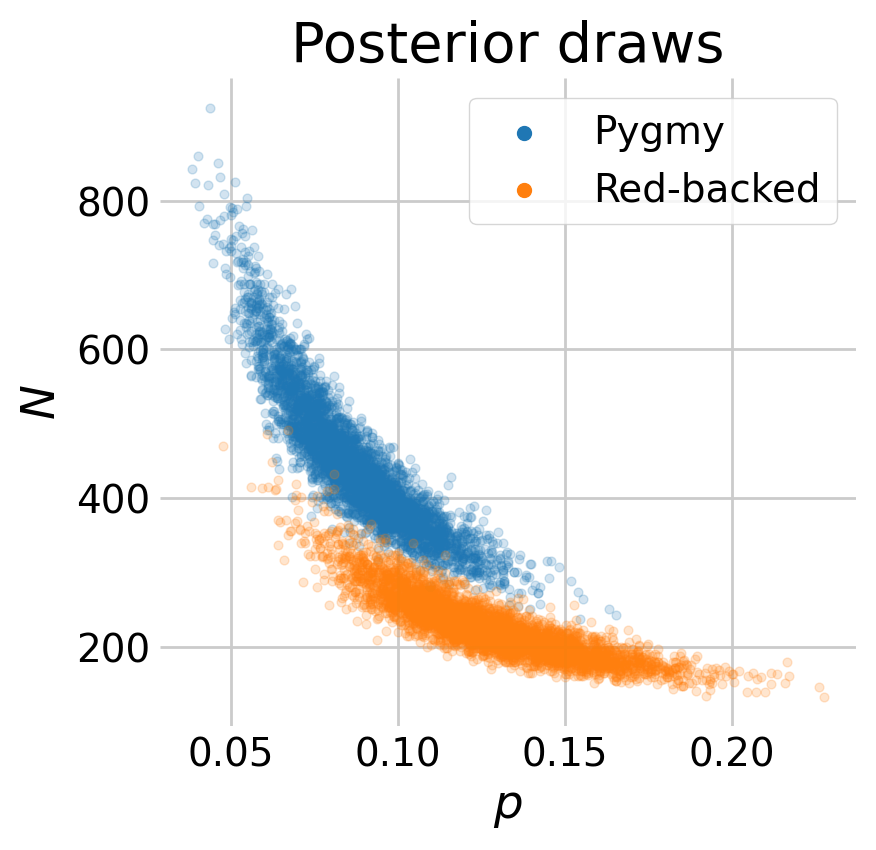

In [9]:
#| fig-cap: Posterior draws of $N$ and $p$ for both species of salamander.
#| label: fig-posterior

# create the plot
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

# add the scatter for each species
labs = ['Pygmy', 'Red-backed']
ax.scatter(p_samps[0], N_pyg, s=10, alpha=0.2, label=labs[0])
ax.scatter(p_samps[1], N_red, s=10, alpha=0.2, label=labs[1])

# this removes the opacity for the dots in the legend
leg = ax.legend()
for lh in leg.legend_handles:
    lh.set(sizes=[25], alpha=[1])

# update aesthetics
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

ax.set_ylabel(r'$N$')
ax.set_xlabel(r'$p$')
ax.set_title('Posterior draws')

plt.show()

# Model $M_b$

Next, I fit model $M_b,$ which accounts for the possibility that the capture probability changes after the animal is first caught. This could be from trap happiness, whereby animals are more likely to be trapped after their first time. Conversely, this could be from subsequent trap avoidance.

Mirroring [@royle2008, Chapter 5], I fit this model to the *Microtus* dataset reported in [@williams2002, Page 525]. This version of the [dataset](https://www.mbr-pwrc.usgs.gov/pubanalysis/roylebook/chapters.htm) includes encounter histories of $n=56$ adult males that were captured on $T=5$ consecutive days.

In [10]:
# read in the microtus data
microtus = np.loadtxt('microtus.data.txt').astype(int)

# the last column is not relevant
micro_hist = microtus[:,:-1]
n, T = micro_hist.shape

# augment with all zero histories
M = 100
micro_augmented = augment_history(micro_hist, M=M)

# note the occasion when each individual was first seen
first_seen = (micro_hist != 0).argmax(axis=1)

# create the covariate for the behavior effect
behavior_effect = np.zeros((M, T))
for i, f in enumerate(first_seen):
    behavior_effect[i, (f + 1):] = 1

# covariate matrix
x_int = np.ones((M, T))
X = np.stack((x_int, behavior_effect), axis=2)

Just like in the occupancy notebook, the detection probability will now be a matrix, i.e., it depends on the individual *and* the occasion. As such, we can no longer rely on `pm.ZeroInflatedBinomial`. Again, just like the occupancy notebook, we will write the model in terms of the latent $z_i$ state, then marginalize it out with `pymc_extras.marginalize()`.

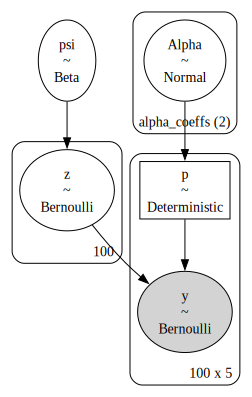

In [11]:
#| fig-cap: Visual representation of model $M_b.$
#| label: fig-mb
coords = {'alpha_coeffs': ['Intercept', 'B_Response']}
with pm.Model(coords=coords) as mb:

    # priors for the capture and inclusion probabilities
    psi = pm.Beta('psi', 0.001, 1)
    Alpha = pm.Normal('Alpha', 0, 2, dims='alpha_coeffs')

    # linear model for the capture probability
    nu = pm.math.dot(X, Alpha)
    p = pm.Deterministic('p', pm.math.invlogit(nu))

    # included / excluded state
    z = pm.Bernoulli('z', psi, shape=M)

    # likelihood for detection given inclusion
    mu_y = z[:, None] * p
    pm.Bernoulli('y', mu_y, observed=micro_augmented)

pm.model_to_graphviz(mb)

In [12]:
mb_marginal = pmx.marginalize(mb, ['z'])
with mb_marginal:
    mb_idata = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [psi, Alpha]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [13]:
az.summary(mb_idata, var_names=['Alpha', 'psi'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Alpha[Intercept],0.111,0.249,-0.378,0.561,0.005,0.005,2122.0,1931.0,1.0
Alpha[B_Response],0.614,0.298,0.043,1.157,0.007,0.006,2007.0,1864.0,1.0
psi,0.572,0.052,0.470,0.665,0.001,0.001,2371.0,1946.0,1.0


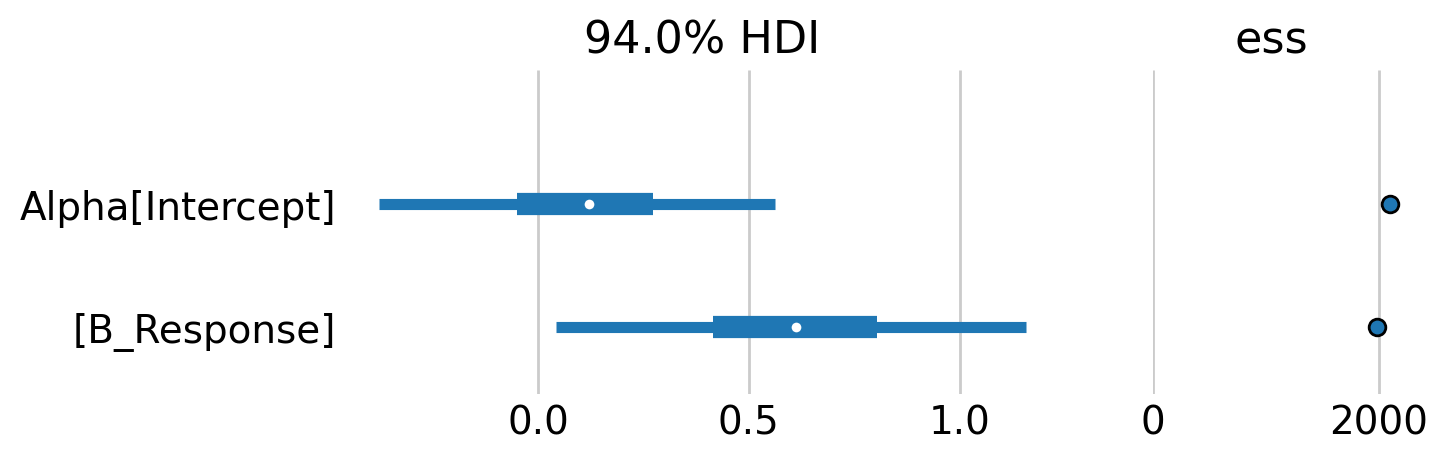

In [14]:
#| fig-cap: Forest plot showing the catchability parameters from model $M_b.$
#| label: fig-forest
az.plot_forest(mb_idata, var_names=['Alpha'], combined=True, ess=True, figsize=(6,2));

The forest plot indicates that there is some evidence of a weak, positive behavioral response. Although note that the 94% credible intervals between the baseline capture rate and the behavioral effect overlap considerably.

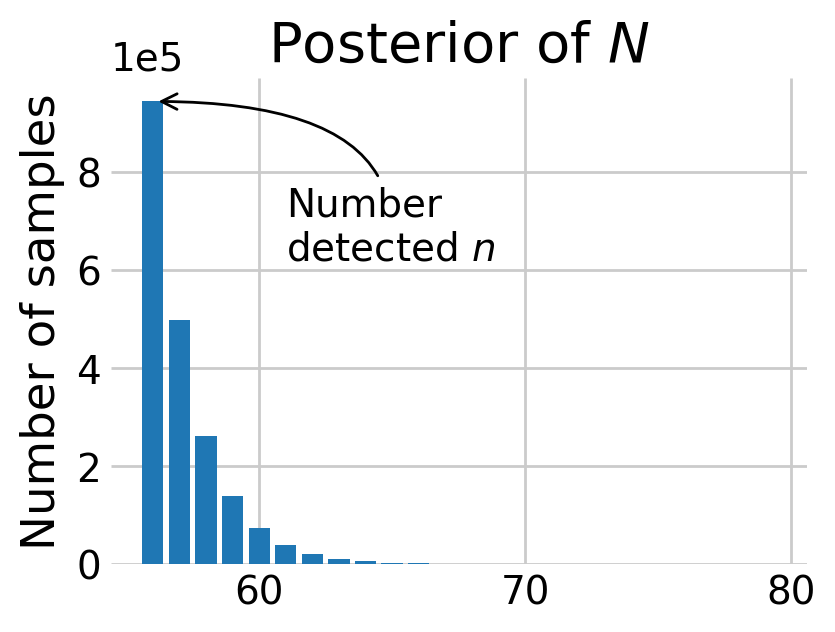

In [15]:
#| fig-cap: Posterior distribution of $N$ from model $M_b.$ The number voles that were detected $n$ is shown by the vertical red line.
#| label: fig-mb_N

# # simulate draws of N
psi_samps = az.extract(mb_idata).psi.values
p_samps = az.extract(mb_idata).p.values

# posterior probabilities of being present in the population but not detected
p_if_present = psi_samps * binom.pmf(0, n=T, p=p_samps)
p_total = p_if_present + (1 - psi_samps)

# simulate the number of undetected animals in each population
number_undetected = RNG.binomial(M - n, p_if_present / p_total)

# simulate N
N = n + number_undetected

# create the plot
fig, ax = plt.subplots(figsize=(4, 3))

# bar plot looks a little better than a histogram here imo
N_values, N_counts = np.unique(N, return_counts=True)
ax.bar(N_values, N_counts)

ax.annotate(
    'Number\ndetected $n$',
    ha='left',
    xy=(N_values[0], N_counts[0]),
    color='black',
    xytext=(n+5, 6.2e5),
    arrowprops=dict(arrowstyle="->", color='black', linewidth=1,
                    connectionstyle="angle3,angleA=90,angleB=0")
)

ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.set_ylabel('Number of samples')
ax.set_title('Posterior of $N$')

plt.show()

Most of the posterior density of $N$ is at $n,$ the number of animals detected. The discovery curve hints at why this may be the case. It seems that all the voles in the population may have been captured by the end of the study.

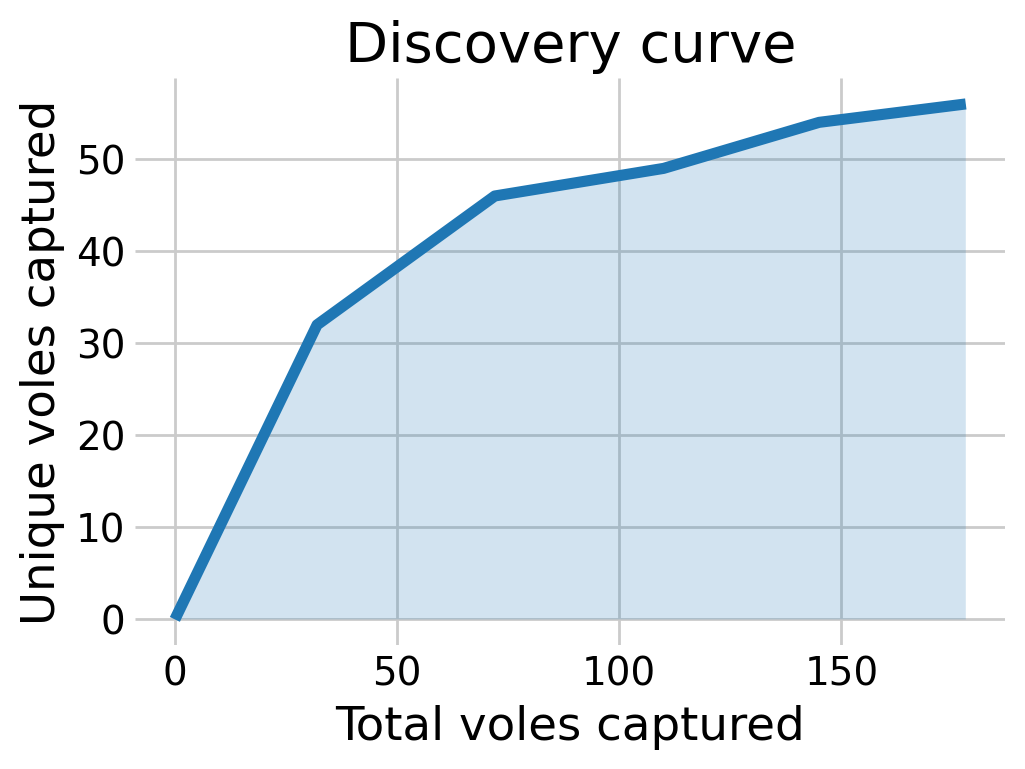

In [16]:
#| fig-cap: Discovery curve for the *Microtus* study.
#| label: fig-discovery

# how many voles have been seen?
total_seen = micro_hist.sum(axis=0).cumsum()
total_seen = np.insert(total_seen, 0, 0)

# how many new voles have been seen?
first_seen = (micro_hist != 0).argmax(axis=1)
newbies = [sum(first_seen == t) for t in range(T)]
total_newbies = np.cumsum(newbies)
total_newbies = np.insert(total_newbies, 0, 0)

fig, ax = plt.subplots(figsize=(5, 3.5))
ax.plot(total_seen, total_newbies)
ax.fill_between(total_seen, total_newbies, alpha=0.2)
ax.set_title('Discovery curve')
ax.set_xlabel('Total voles captured')
ax.set_ylabel('Unique voles captured')
plt.show()

We can also look at the behavioral effect by visualizing the posterior distributions of $p.$ As we can see, the voles who have been captured before are more likely to be captured again.

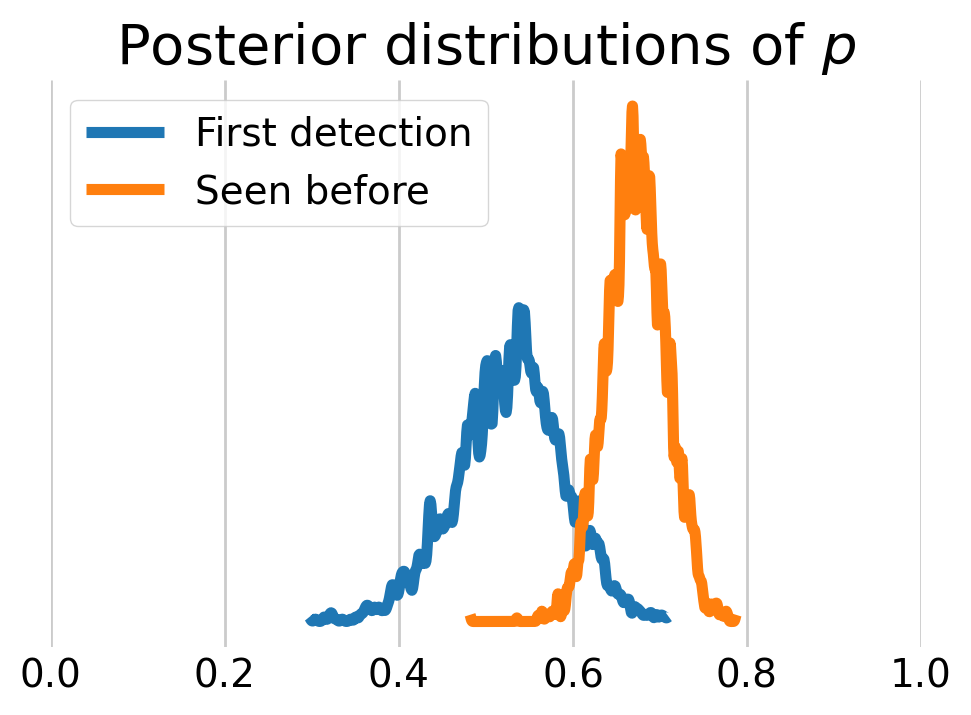

In [17]:
#| fig-cap: Posterior distributions for the probability of detection given the behavioral effect.
#| label: fig-b_effect

first_detection = X[:, :, 1] == 0
p_first_detection = p_samps[first_detection].flatten()
p_seen_before = p_samps[~first_detection].flatten()

fig, ax = plt.subplots(figsize=(5, 3.5))
az.plot_dist(p_first_detection, ax=ax, label='First detection', color='C0')
az.plot_dist(p_seen_before, ax=ax, label='Seen before', color='C1')
ax.set_title('Posterior distributions of $p$')
ax.set_xlim((0,1))
ax.set_yticks([])
ax.legend()
plt.show()

## Model $M_t$

We can also look at time varying effects with model $M_t.$

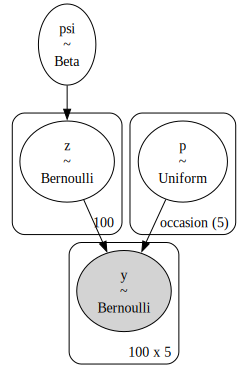

In [18]:
#| fig-cap: Visual representation of model $M_b.$
#| label: fig-mt
coords = {'occasion': np.arange(T)}
with pm.Model(coords=coords) as mt:

    # priors for the capture and inclusion probabilities
    psi = pm.Beta('psi', 0.001, 1)
    p = pm.Uniform('p', 0, 1, dims='occasion')

    # included / excluded state
    z = pm.Bernoulli('z', psi, shape=M)

    # likelihood for detection given inclusion
    mu_y = z[:, None] * p
    pm.Bernoulli('y', mu_y, observed=micro_augmented)

pm.model_to_graphviz(mt)

Broadcasting `z` across `p`, now that `p` is a vector, produces a matrix. The first row of this matrix, `mu_y[0]`, contains the first value of the state variable, `z[0]`, multiplied against every value of the detection probability vector `p[0:T]`, i.e., `p`.

In [19]:
mt_marginal = pmx.marginalize(mt, ['z'])
with mt_marginal:
    mt_idata = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [psi, p]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [20]:
az.summary(mt_idata, var_names=['p', 'psi'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p[0],0.566,0.063,0.446,0.677,0.001,0.001,6026.0,3435.0,1.0
p[1],0.701,0.058,0.590,0.808,0.001,0.001,5728.0,3199.0,1.0
p[2],0.670,0.062,0.544,0.773,0.001,0.001,6300.0,3317.0,1.0
p[3],0.618,0.064,0.499,0.738,0.001,0.001,4984.0,3195.0,1.0
p[4],0.583,0.065,0.463,0.709,0.001,0.001,5870.0,3096.0,1.0
psi,0.558,0.050,0.464,0.650,0.001,0.001,5837.0,3171.0,1.0


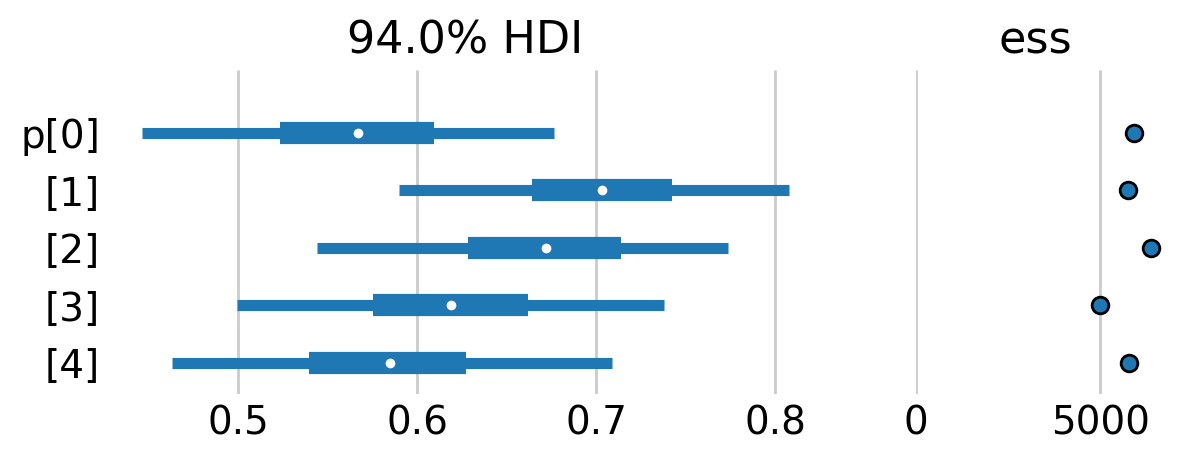

In [21]:
#| fig-cap: Forest plot showing the variation in the detection probability from model $M_b.$
#| label: fig-forest-mt
az.plot_forest(mt_idata, var_names=['p'], combined=True, ess=True, figsize=(6,2));

For the most part, it doesn't look as if the detection prbobability varied dramatically across the study.

## Model $M_{h}$

We can also model individual effects with model $M_h$.

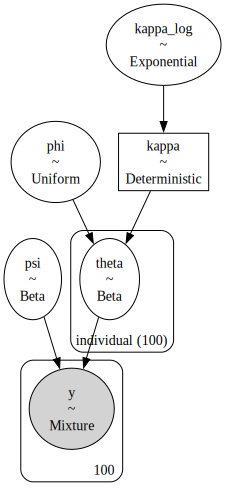

In [ ]:
#| fig-cap: Visual representation of model $M_h.$
#| label: fig-mh
coords = {'individual': np.arange(M)}
with pm.Model(coords=coords) as mh:

    # priors for the capture and inclusion probabilities
    psi = pm.Beta('psi', 0.001, 1)

    # overall average
    phi = pm.Uniform("phi", lower=0.0, upper=1.0)

    # individual level variation
    kappa_log = pm.Exponential("kappa_log", lam=1.5)
    kappa = pm.Deterministic("kappa", pm.math.exp(kappa_log))
    theta = pm.Beta("theta", alpha=phi * kappa, beta=(1.0 - phi) * kappa, dims="individual")

    pm.ZeroInflatedBinomial(
        'y',
        p=theta,
        psi=psi,
        n=T,
        observed=micro_augmented.sum(axis=1)
    )

pm.model_to_graphviz(mh)

In [26]:
with mh:
    mh_idata = pm.sample(target_accept=0.99)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [psi, phi, kappa_log, theta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [27]:
az.summary(mh_idata, var_names=['psi', 'phi', 'kappa'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
psi,0.716,0.098,0.542,0.911,0.004,0.002,579.0,836.0,1.00
phi,0.499,0.073,0.357,0.630,0.003,0.001,561.0,1148.0,1.00
kappa,1.422,0.440,1.000,2.225,0.025,0.036,367.0,532.0,1.01


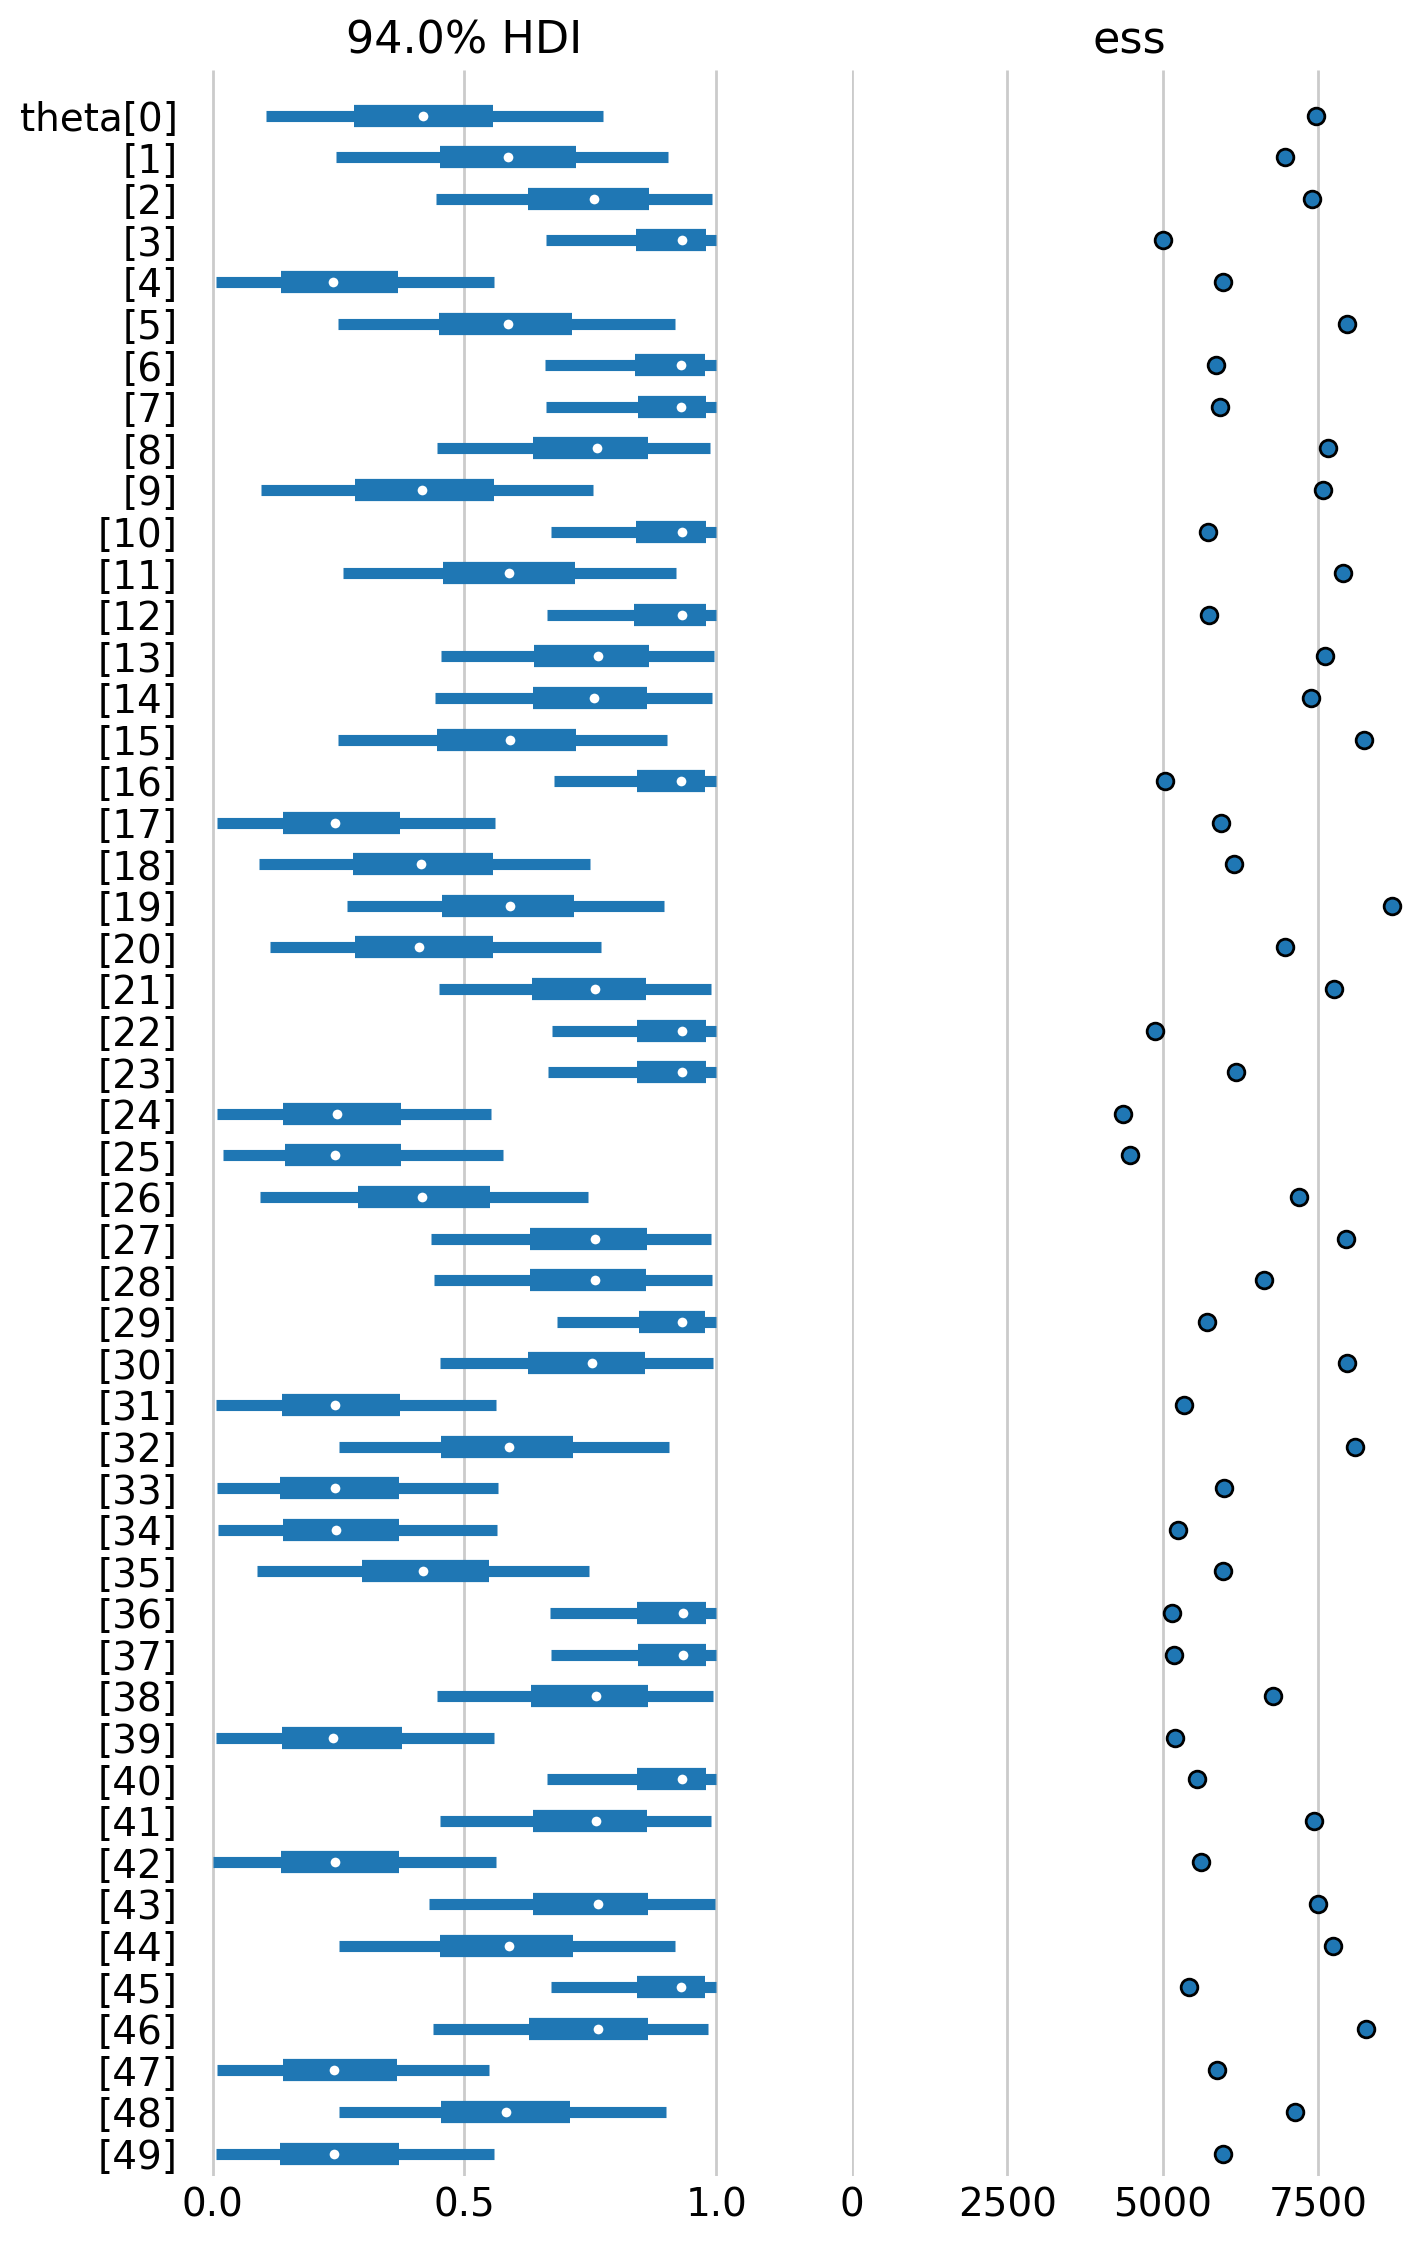

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(7, 13), sharey=True)

az.plot_forest(mh_idata, var_names="theta", combined=True, ess=True, ax=axes,
               coords={'individual': np.arange(50)});

In [ ]:
%load_ext watermark

%watermark -n -u -v -iv -w